<a href="https://colab.research.google.com/github/AtishaySinghai/handwriting_to_text/blob/main/After_saving_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting recognition - words - loading model


## Introduction

This program predicts handwritten words by succesfully **Loading** an already trained model of epoch= 100 and uses it to predict new images.

## Data collection

In [2]:
#Downloading dataset from gdrive link- https://drive.google.com/drive/folders/1LLW9iuEIYmvAuptKIAe8njkzNCBnpveE?usp=sharing
!gdown --id 1Y76_N7NILXVm7bfjayfqjuNTJE8qU8Oy   # model100.h5
!gdown --id 17J7c4SO0ZnD-gsg6LuoiTNeNVhaXINEh   # words.txt
!gdown --id 1jkYVAofJFkzlMLh0uQOjos_9Z13G1zCa   # words.tgz

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Y76_N7NILXVm7bfjayfqjuNTJE8qU8Oy
To: /content/model100.h5
100% 5.18M/5.18M [00:00<00:00, 163MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=17J7c4SO0ZnD-gsg6LuoiTNeNVhaXINEh
To: /content/words.txt
100% 5.30M/5.30M [00:00<00:00, 131MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=

In [3]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
!mkdir data                                                           # to make a new directory/folder
!cp /content/words.txt data                                           # to make a copy
!mkdir data/words                                                     
!tar -xf /content/words.tgz -C data/words                             # used to create Archive and extract the Archive files
                                                                      # -x : Extract the archive
                                                                      # -f : creates archive with given filename
                                                                      # -c : Creates Archive 

In [5]:
!head -20 /content/data/words.txt                                     # to read top 20 lines

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


In [6]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":                                  # We don't need to deal with errored entries.
        words_list.append(line)                                      # word_list = []     

print("Total words:",len(words_list))

np.random.shuffle(words_list)                                        # list jumbled

Total words: 96456


In [7]:
split_idx = int(0.9 * len(words_list))                                    # using 90% of word_list to train model
train_samples = words_list[:split_idx]                                    
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)
                                                                          # spliting into 3 parts
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [8]:
base_image_path = os.path.join(base_path, "words")                      # 'data/words'


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):                                   # enumerate converts list to --> (0, seq[0]), (1, seq[1]), (2, seq[2]),...
        line_split = file_line.strip()                                          # remove spaces at the beginning and at the end
        line_split = line_split.split(" ")
                                                                                # Each line split will have this format for the corresponding image:
                                                                                # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]                                        # part I  = 'g01'
        partII = image_name.split("-")[1]                                       # part II = '067'
        img_path = os.path.join(                                                # eg- 'data/words/g01/g01-067/g01-067-03-02.png'
            base_image_path, partI, partI + "-" + partII, image_name + ".png")
        
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])                  #just remove '\n' from word_list and added to label

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [9]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:                              # reading each new letter and adding to set
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]                           # only words list

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [10]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

                                            # making just words list for rest 2 lists (train_cleaned during making chracter set)
validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [12]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(                                                  # adding padding to picture to make all image of same size
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])           # 1 
    image = tf.image.flip_left_right(image)               # left to right
    return image


In [13]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)                                 # returns tf.Tensor([[,,],[]...] of pixels RGB values list
    image = tf.image.decode_png(image, 1)                               # 1: output a grayscale image -> 1 number array instrad of 3 in RGB
    image = distortion_free_resize(image, img_size)                     # --> distortion_free_resize
    image = tf.cast(image, tf.float32) / 255.0                          # colour highest value(255) ; making the array b/w 0-1
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))    # -->  char_to_num -> converts a string to a sequence of integers
    length = tf.shape(label)[0]                                                     # returns lenght 
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token) # adding values to padded areas so we dont read those
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)                                        # --> preprocess_image
    label = vectorize_label(label)                                              # --> vectorize_label
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE                      # --> process_images_labels
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [14]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

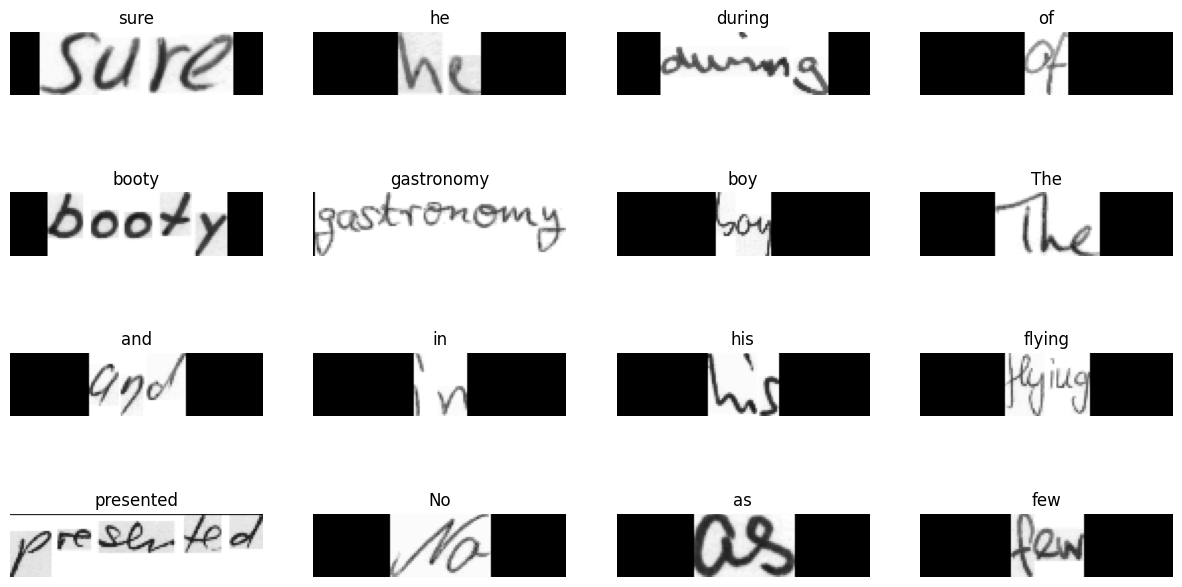

In [15]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()

## Loading the already trained model

In [16]:
from keras.models import load_model
import keras.losses

# Define the custom layer class
class CTCLayer(tf.keras.layers.Layer):
    # Implementation of the custom layer...
    pass

# Register the custom layer when loading the model
with keras.utils.custom_object_scope({'CTCLayer': CTCLayer}):
    model = load_model('/content/model100.h5')

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [18]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [19]:
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [20]:
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)          # --> EditDistanceCallback -> calculate_edit_distance

2/2 [==============================] - 2s 90ms/step


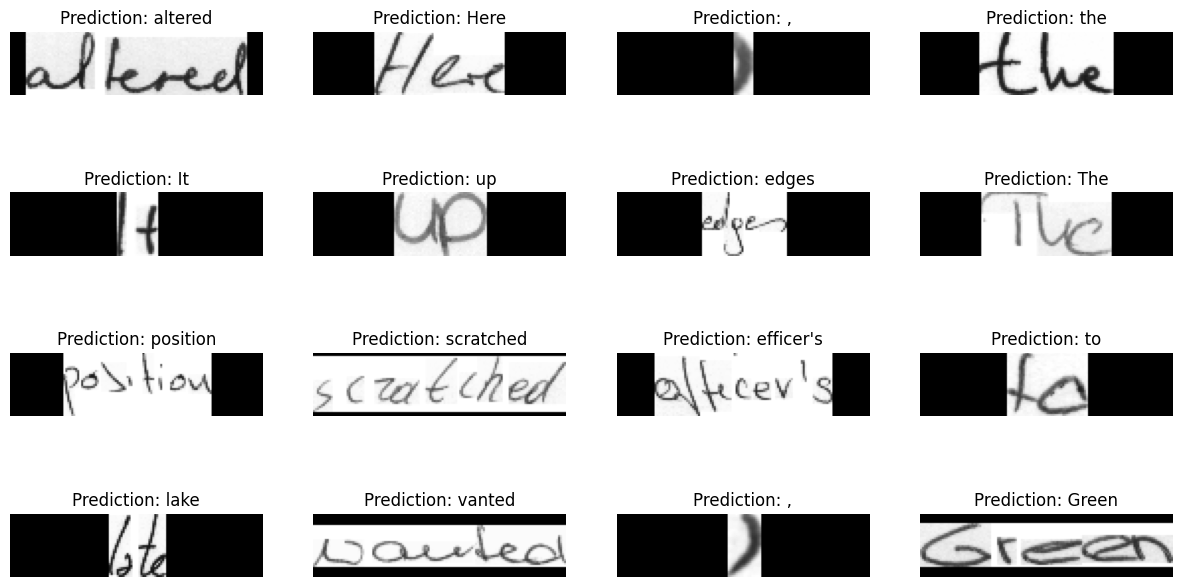

In [21]:
# A utility function to decode the output of the network.

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)                   # --> model retrived in prev code
    pred_texts = decode_batch_predictions(preds)                     # 

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()



---



## To test 1  random picture

You can also test this code by adding picture of your own by changing the image_path_new


In [26]:
def process_images_labels2(image_path):
    image = preprocess_image(image_path)                                        # --> preprocess_image
    return {"image": image}

def prepare_dataset2(image_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths)).map(
        process_images_labels2, num_parallel_calls=AUTOTUNE                     # --> process_images_labels
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [27]:
import random                                     # evertime this code runs, it will show different results

image_path_new = test_img_paths[random.randint(0,len(test_samples)-1)]          # replacing it with "/path"

test_ds1 = prepare_dataset2([image_path_new])

1/1 [==============================] - 0s 36ms/step


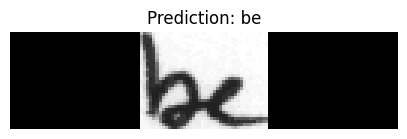

In [28]:
# ONLY for 1 picture 

for batch in test_ds1.take(1):
    batch_images = batch["image"]
    
    _, ax = plt.subplots(1, 1, figsize=(5, 3))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(1):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

plt.show()